> # Head Pose Estimation 

## Install mediapipe

In [3]:
%%capture
!pip install mediapipe

## Get the dataset 

In [4]:
!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

--2022-06-17 06:38:17--  http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
Resolving www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)... 159.226.21.60
Connecting to www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)|159.226.21.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87413900 (83M) [application/x-zip-compressed]
Saving to: ‘AFLW2000-3D.zip’

AFLW2000-3D.zip     100%[===================>]  83.36M   288KB/s    in 5m 3s   

2022-06-17 06:43:20 (282 KB/s) - ‘AFLW2000-3D.zip’ saved [87413900/87413900]



In [ ]:
!unzip /content/AFLW2000-3D.zip

## Import libraries

In [1]:
import mediapipe as mp
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio
from math import cos, sin
from google.colab.patches import cv2_imshow

## Read the dataset 

In [2]:
# images files
images = sorted(glob.glob("/content/AFLW2000/*.jpg"))
len(images)

2000

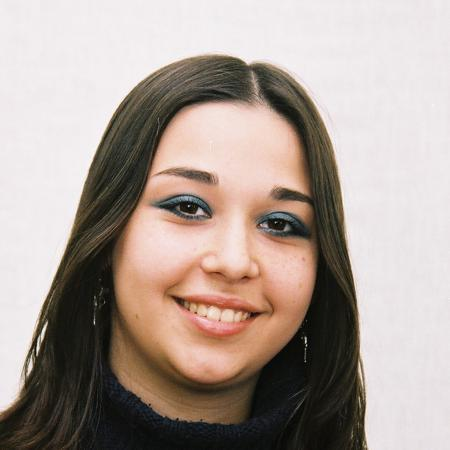

In [3]:
# read and look at exampple image using cv2
img = cv2.imread(images[25])
cv2_imshow(img)

In [4]:
img.shape

(450, 450, 3)

In [5]:
# angles file
angles_files= sorted(glob.glob("/content/AFLW2000/*.mat"))
len(angles_files)

2000

---
# Functions 



In [6]:
def extract_angles(file):
  labels = []
  
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  mat_file = sio.loadmat(file)
  # extracting the labels 3 angels
  pose_param = mat_file["Pose_Para"][0][:3]
  #print(pose_param)

  return pose_param

In [7]:
def extract_data(images, files):
  features = []
  labels = []

  # init face mesh
  face_mesh = mp.solutions.face_mesh.FaceMesh()

  for (image, file) in zip(images, files):
    # read the image 
    img = cv2.imread(image)
    height, width, _ = img.shape

    # process image to get the 468 point of face 
    result = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # loop over every face in the image
    if result.multi_face_landmarks != None:
      for face_landmarks in result.multi_face_landmarks:
        image_list = []
        # loop over each landmark point in the face
        for i in range(0, 468):
          # get the point
          point = face_landmarks.landmark[i] 
          # get the pixels 
          x = point.x 
          y = point.y
          relative_x = int(x * width)
          relative_y = int(y * height)
          # append point to image feature
          image_list.append(relative_x)
          image_list.append(relative_y)

        # drow a small circle of the land mark
        #cv2.circle(img, (x, y), 2, (100, 100, 0), -1)

        # append image to data features
        features.append(image_list)

        # get angles of the image then append them to labels 
        pose_param = extract_angles(file)
        labels.append(pose_param)

  # convert to numpy array to create dataframe
  features = np.array(features)
  labels = np.array(labels)

  return pd.DataFrame(features), pd.DataFrame(labels, columns = ['pitch', 'yaw', 'roll'])

In [8]:
def normalize(features):
  df_normalize = features.copy()

  # 1 - center all points at the point number 1 : nose
  for i in range(936):
    if i % 2 == 0:
      # normalize x
      df_normalize[i] = df_normalize[i] - df_normalize[2]

    else:
      # normalize y
      df_normalize[i] = df_normalize[i] - df_normalize[3]

  # 2 - divide all points by distince between two points (nose, head)
  df_normalize['lx'] = df_normalize[20] - df_normalize[2]
  df_normalize['ly'] = df_normalize[21] - df_normalize[3]
  df_normalize['norm'] = np.linalg.norm(df_normalize[['lx', 'ly']].values, axis=1)

  df_normalize.iloc[:, :] = df_normalize.iloc[:, :].div(df_normalize['norm'], axis=0)
  df_normalize.drop(['lx', 'ly', 'norm'], axis=1, inplace=True)

  return df_normalize



---



## Extract features and labels from data

In [9]:
features, labels = extract_data(images, angles_files)

features.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,218,309,220,287,220,291,215,253,220,279,...,251,218,246,221,243,225,299,212,304,208
1,192,296,180,271,194,279,186,247,179,264,...,230,226,225,228,220,230,269,227,275,221
2,219,299,200,279,214,285,199,255,197,272,...,230,230,226,233,222,235,260,225,264,219
3,226,309,210,291,220,294,199,263,207,284,...,228,226,224,229,221,233,269,209,273,204
4,188,305,167,279,185,285,170,257,164,273,...,207,230,202,234,197,236,233,224,237,219


In [10]:
features.shape

(1791, 936)

In [11]:
labels.head()

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.882169,1.198004,-1.033374


In [12]:
labels.shape

(1791, 3)

## Normalize features

In [13]:
features_normalized = normalize(features)

In [14]:
features_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-0.007431,0.081737,0.0,0.0,0.817370,1.081157,0.798793,0.939975,0.817370,1.036573,...,0.932544,0.809939,0.913968,0.821085,0.902822,0.835946,1.110880,0.787647,1.129456,0.772786
1,0.045553,0.094903,0.0,0.0,0.736446,1.059115,0.706077,0.937640,0.679504,1.002174,...,0.873106,0.857921,0.854125,0.865514,0.835145,0.873106,1.021154,0.861717,1.043931,0.838941
2,0.072956,0.076795,0.0,0.0,0.821711,1.094334,0.764114,0.979141,0.756434,1.044417,...,0.883147,0.883147,0.867788,0.894666,0.852429,0.902346,0.998340,0.863948,1.013699,0.840909
3,0.064758,0.072853,0.0,0.0,0.890426,1.189932,0.805430,1.064463,0.837810,1.149458,...,0.922805,0.914710,0.906615,0.926852,0.894473,0.943042,1.088748,0.845904,1.104937,0.825667
4,0.084131,0.104163,0.0,0.0,0.741157,1.141783,0.681063,1.029607,0.657026,1.093708,...,0.829295,0.921439,0.809263,0.937464,0.789232,0.945476,0.933457,0.897401,0.949482,0.877370


## Split the data to train and valid

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

In [16]:
print(x_train.shape)
print(y_train.shape)

print()

print(x_valid.shape)
print(y_valid.shape)

(1432, 936)
(1432, 3)

(359, 936)
(359, 3)


## The Machine Learning Model : SVR

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
 

In [18]:
svr = SVR(kernel='rbf', C=3, epsilon=0.1, degree=3, tol=0.00001)
multi_out_svr = MultiOutputRegressor(svr)

multi_out_svr.fit(x_train, y_train)
print("R2_ score : train = ", multi_out_svr.score(x_train, y_train))

y_pred = multi_out_svr.predict(x_valid)
print("R2_score: test =  ", r2_score(y_valid, y_pred))

R2_ score : train =  0.6905893116351773
R2_score: test =   0.7075634615004617




---

# Testing the model 

In [19]:
def extract_image_landmarks(image):
  features = []
  labels = []

  # init face mesh
  face_mesh = mp.solutions.face_mesh.FaceMesh()

  # read the image 
  #img = cv2.imread(image)
  img = image
  height, width, _ = img.shape

  # process image to get the 468 point of face 
  result = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  # loop over every face in the image
  if result.multi_face_landmarks != None:
    for face_landmarks in result.multi_face_landmarks:
      image_list = []
      # loop over each landmark point in the face
      for i in range(0, 468):
        # get the point
        point = face_landmarks.landmark[i] 
        # get the pixels 
        x = int(point.x * width)
        y = int(point.y *height)
        image_list.append(x)
        image_list.append(y)

      features.append(image_list)

  features = np.array(features)

  return pd.DataFrame(features)

In [20]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red pitch
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green yaw
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue roll
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [21]:
def draw_mesh(img, points):
  #drow a small circle of the land mark
  for i in range(0, len(points), 2):
    cv2.circle(img, (points[i], points[i+1]), 2, (100, 100, 0), -1)

  return img

## Test on image

In [22]:
image_test = '/content/AFLW2000/image00067.jpg'
img = cv2.imread(image_test)

# extract landmarks
x_test = extract_image_landmarks(img)

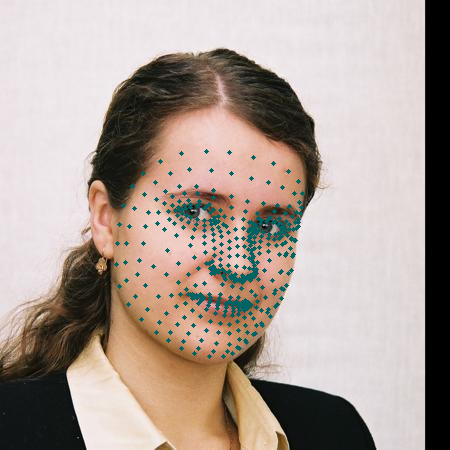

In [23]:
# plot face mesh
img_mesh = draw_mesh(img, x_test.iloc[0].tolist())

cv2_imshow(img_mesh)

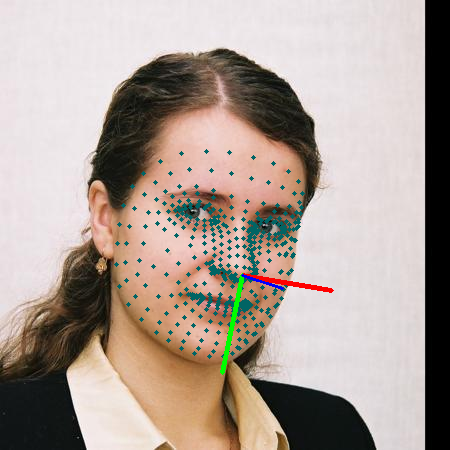

In [24]:
# normalize data
x_test_norm = normalize(x_test)

# predict angles
y_pred = multi_out_svr.predict(x_test_norm)

# draw axis
cv2_imshow(draw_axis(img, y_pred[0][0], y_pred[0][1], y_pred[0][2], x_test[2][0], x_test[3][0]))



---



# Test on Video 

In [27]:
cap = cv2.VideoCapture("/content/test_lolo2.mp4")
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_name = 'out_lolo.mp4'
video = cv2.VideoWriter(video_name, fourcc, 20, (width,height))

while (cap.isOpened()):

  # reading from frame
  success, frame = cap.read()

  if success is not True:
    break

  # extraxt landmarks from image
  x_test = extract_image_landmarks(frame)
  # normalize data
  x_test_norm = normalize(x_test)

  # predict angles
  y_pred = multi_out_svr.predict(x_test_norm)

  # draw axis 
  out_img = draw_axis(frame, y_pred[0][0], y_pred[0][1], y_pred[0][2], x_test[2][0], x_test[3][0])
  # write frame to video
  video.write(out_img)

# Release all space and windows once done
cv2.destroyAllWindows()
video.release()
